<a href="https://colab.research.google.com/github/1122coder/Fractured-Bone-detection-classifier/blob/main/fractured_bone_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

¢
                                      **Fractured Bone Detection Classifier**

```

Necessery Libraries are being imported

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.image as mpimg
import os
import random
from PIL import Image
from dask import bag, diagnostics
import pywt  # Import the PyWavelets library
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import logging
%matplotlib inline

**EDA on Image Dataset**
---

*   Bar Chart
*   Pie Chart
*   Dimentions checking
*   listing pictures from each directory






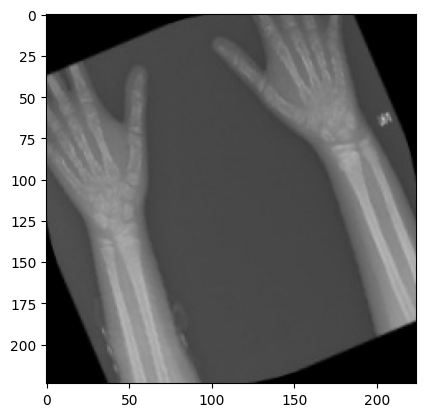

In [ ]:
img_dataset = cv2.imread('/content/drive/MyDrive/dataset/train/fractured/10-rotated1-rotated1-rotated3.jpg')
plt.imshow(img_dataset)

In [ ]:

train_data = '/content/drive/MyDrive/dataset/train'
val_data = '/content/drive/MyDrive/dataset/val'

In [ ]:

fractured= '/content/drive/MyDrive/dataset/train/fractured'
not_fractured= '/content/drive/MyDrive/dataset/train/not_fractured'

title = fractured.split('/')[-1]
print(title)
print(len(os.listdir(fractured)))
print(len(os.listdir(not_fractured)))


fractured
4551
4393


In [ ]:
number_classes = {'Class_0': len(os.listdir(fractured)),
'Class_1': len(os.listdir(not_fractured))}

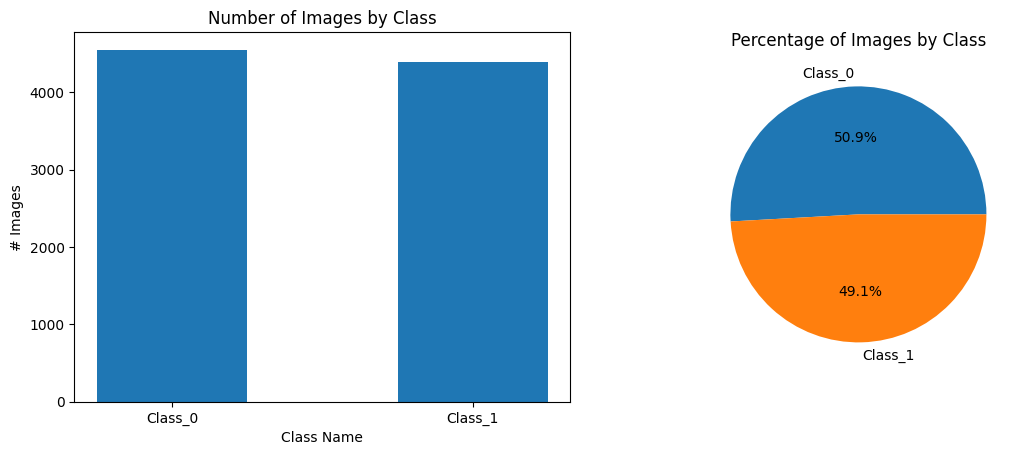

In [ ]:
#pie chart
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

#bar chart
plt.axes([1.1,0, 0.5, 1])
plt.pie(number_classes.values(), labels=number_classes.keys(), autopct='%1.1f%%')
plt.title("Percentage of Images by Class")
plt.show()

In [ ]:
directories = {'Class_0': fractured+'/',
'Class_1': not_fractured+'/'}

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)

    if len(arr.shape) == 2:  # Grayscale image (height, width)
        h, w = arr.shape
        d = 1  # Set depth to 1 for grayscale
    elif len(arr.shape) == 3:  # RGB image (height, width, depth)
        h, w, d = arr.shape
    else:
        return None, None, None  # Return None values for unsupported image

    if h >= 200 and d == 3:  # Check if height is >= 200 and it's an RGB image
        return h, w, im
    else:
        return h, w, None


[########################################] | 100% Completed | 27.92 s


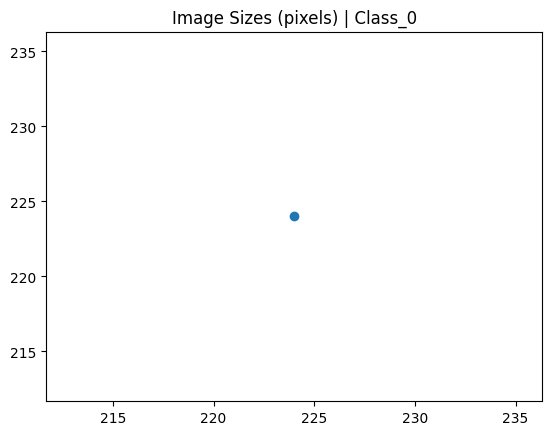

[########################################] | 100% Completed | 136.62 s


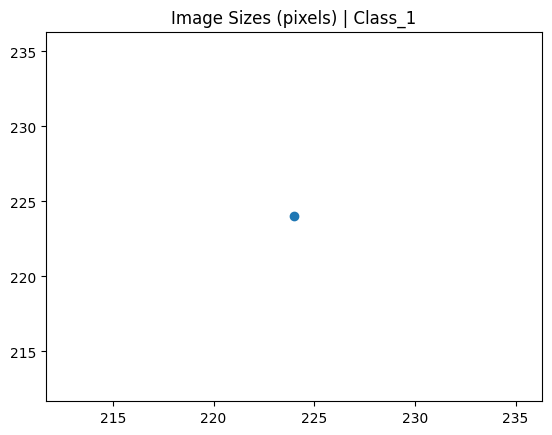

In [ ]:
for n, d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width', 'image'])
        dim_df = dim_df.dropna()  # Drop rows with None values (images that didn't meet conditions)
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        plt.scatter(x=sizes['width'], y=sizes['height'])
        plt.title('Image Sizes (pixels) | {}'.format(n))
        plt.show()

In [ ]:
#creating a fuction to show images of fractured and non fractured images
def show_images_x_rays(dir, num_imgs):
  #title fetching from path dir name
  title= dir.split('/')[-1]

  #print('heool')
  imgs_files = [f for f in os.listdir(dir) if f.endswith('.png') or f.endswith('.jpg')]
  #print(imgs_files)
  selected_imgs = random.sample(imgs_files, num_imgs)
  #print(len(selected_imgs))

  plt.figure(figsize= (15,10))
  for i , img_file in enumerate(selected_imgs, 1):
    image_path= os.path.join(dir, img_file)
    img =mpimg.imread(image_path)

    plt.subplot(2, num_imgs, i)
    plt.imshow(img)

    plt.axis('off')
    plt.title(title)

  plt.tight_layout()
  plt.show()






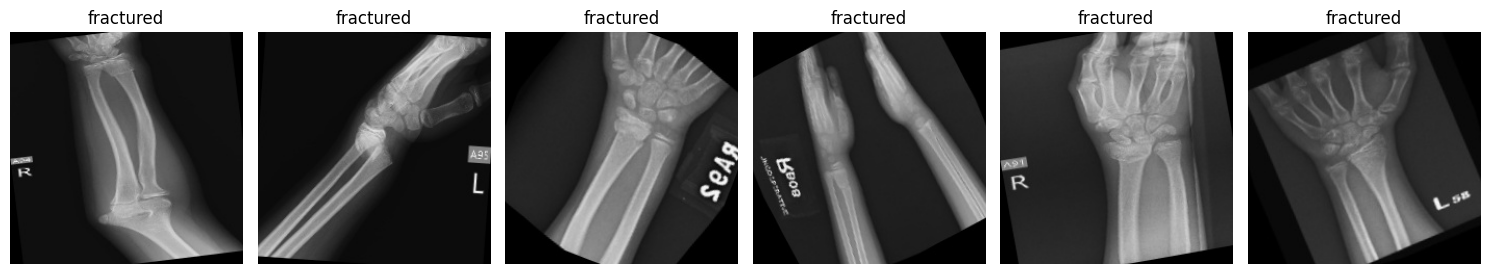

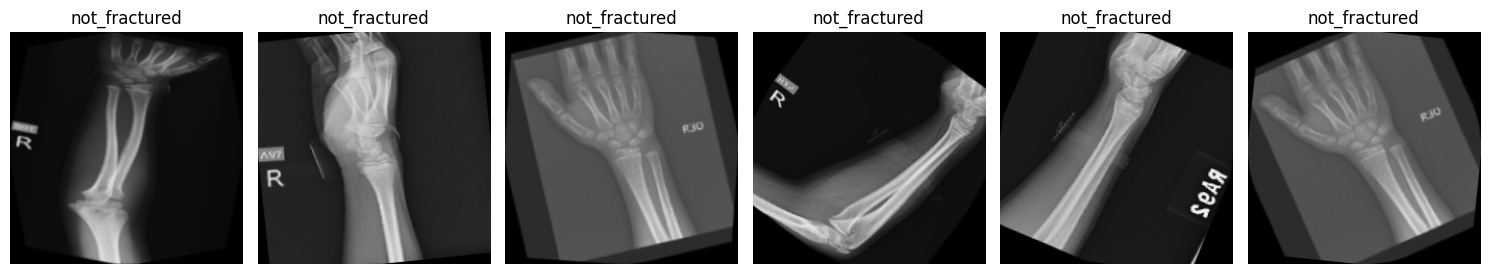

In [ ]:
show_images_x_rays(fractured, 6)
show_images_x_rays(not_fractured, 6)

**PRE-PROCESSING TASKS**
---
*   Wavelet Transform
*   RGB to Gray scale

In [ ]:

# Define a function for wavelet transform denoising
def apply_wavelet_denoising(image):
    coeffs = pywt.dwt2(image, 'haar')  # Perform 2D Discrete Wavelet Transform
    cA, (cH, cV, cD) = coeffs
    threshold = np.std(cD) * np.sqrt(2 * np.log(len(image)))

    if threshold == 0:

      denoised_image = cD
    else:
      thresholded_cD = (1 - cD / threshold) * cD
      denoised_image = pywt.idwt2((cA, (cH, cV, thresholded_cD)), 'haar')

    print("Image denoised in Wavelet method")
    return denoised_image

In [ ]:

def garyScale_transformed_img(input_fold, output_fold):

  print(f'{input_fold} and {output_fold}')
  imgs_files = [f for f in os.listdir(input_fold) if f.endswith(('.jpg', '.jpeg', '.png'))]
  for img in imgs_files:
    img_path = os.path.join(input_fold, img)
    img_rgb = cv2.imread(img_path)
    if img_rgb is not None:
      img_gray= cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
      img_transformed = apply_wavelet_denoising(img_gray)
      print("Wavelet performed on image")
      output_path = os.path.join(output_fold, img)
      cv2.imwrite(output_path, img_transformed)
    else:
      print(f'Image can not be read {img_rgb}')
      continue


In [ ]:
#transformed_images = garyScale_transformed_img(fractured)

In [ ]:
#putting denoised images into separate folder
input_dataset_dir = "/content/drive/MyDrive/dataset1/train"
output_dataset_dir = "/content/drive/MyDrive/dataset1/denoised_train"
input_dataset_dir = "/content/drive/MyDrive/dataset1/val"
output_dataset_dir = "/content/drive/MyDrive/dataset1/denoised_val"

garyScale_transformed_img(os.path.join(input_dataset_dir, 'fractured'), os.path.join(output_dataset_dir, 'fractured'))
garyScale_transformed_img(os.path.join(input_dataset_dir, 'not fractured'), os.path.join(output_dataset_dir, 'not fractured'))



In [ ]:
input_dataset_dir = "/content/drive/MyDrive/dataset1/val"
output_dataset_dir = "/content/drive/MyDrive/dataset1/denoised_val"

garyScale_transformed_img(os.path.join(input_dataset_dir, 'fractured'), os.path.join(output_dataset_dir, 'fractured'))
garyScale_transformed_img(os.path.join(input_dataset_dir, 'not fractured'), os.path.join(output_dataset_dir, 'not fractured'))



**PreProcessing, model building, compiling and Training**

---
*   Image Data Generator(Data Augmentaton, normalizing, resizing)
*   CNN model building
*   Compilation
*   Model training





In [ ]:
learning_rates= [0.005, 0.001]
batch_sizes = [32, 64]
num_epochs = 32
dropout_rates = [0.3, 0.5]
regulariztion_tec = [0.001, 0.0001]
expected_classes= ['fractured', 'not_fractured']
for lr in learning_rates:
  for b_s in batch_sizes:
    for d_r in dropout_rates:
      for r_t in regulariztion_tec:
        data_gen = image.ImageDataGenerator(
            rescale=1.0/255.0,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest',
            )
        val_gen = image.ImageDataGenerator(
            rescale = 1.0/255.0
        )

        #base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))

        #for layer in base_model.layers:
          #layer.trainable= False

        model = tf.keras.Sequential([
        #base_model,

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(224,224,3),kernel_regularizer=l2(r_t)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2,2)),


        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(d_r),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(d_r),

        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(d_r),

        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

        print(model.summary())
        #compiling the model here
        model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy', 'Precision'])

        #now data is being generated
        train_datagen= data_gen.flow_from_directory(
        train_data,
        target_size=(224, 224),
        class_mode='binary',
        batch_size=b_s,
        classes=expected_classes,
        )

        val_datagen= val_gen.flow_from_directory(
        val_data,
        target_size=(224, 224),
        class_mode='binary',
        batch_size=b_s,
        classes=expected_classes,
        )

         # Apply wavelet denoising to training images
        """denoised_train_images = []
        for image_batch, _ in train_datagen:
            for image in image_batch:
                denoised_image = apply_wavelet_denoising(image)
                denoised_train_images.append(denoised_image)
            if len(denoised_train_images) >= len(train_datagen) * b_s:
                break
        denoised_train_images = np.array(denoised_train_images)

        # Apply wavelet denoising to validation images
        denoised_val_images = []
        for image_batch, _ in val_datagen:
            for image in image_batch:
                denoised_image = apply_wavelet_denoising(image)
                denoised_val_images.append(denoised_image)
            if len(denoised_val_images) >= len(val_datagen) * b_s:
                break
        denoised_val_images = np.array(denoised_val_images) """


        model_checkpoint= ModelCheckpoint("Fractured_bone_detection.h5", save_best_only=True)
        early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
        tensorboard = TensorBoard(log_dir='logs')

        #Now training the model
        logging.info(f"Training with learning_rate={lr}, batch_size={b_s}, dropout_rate={d_r}, l2_regularization={r_t}")
        history = model.fit(
        train_datagen,
        epochs=10,
        steps_per_epoch=train_datagen.samples // b_s,
        validation_data=val_datagen,
        validation_steps= val_datagen.samples // b_s,
        callbacks=[model_checkpoint, early_stopping, tensorboard]
        )
        logging.info(f"Training complete. Best validation accuracy: {max(history.history['val_accuracy'])}")



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 128)    0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 batch_normalization_4 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                      

**Extra / optional work**
 The model is quite important and must be preprocessed carefully Above model is carefully developed. you only need are Computational power and Hardware resources - model is learning exceptionally well.
Do not use below model for real life classification as it will not perform well and has been developed for educational and research purposes.

In [ ]:
data_gen = image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
    )
val_gen = image.ImageDataGenerator(
    rescale = 1.0/255.0
)

#now data is being generated
expected_classes = ['fractured', 'not_fractured']
train_folder= "/content/drive/MyDrive/dataset1/denoised_train"
train_datagen= data_gen.flow_from_directory(
  train_folder,
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32,
  classes=expected_classes,
)

val_folder = "/content/drive/MyDrive/dataset1/denoised_val"
val_datagen= val_gen.flow_from_directory(
  val_data,
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32,
  #classes=expected_classes,
)

Found 4534 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
model = tf.keras.Sequential([
#base_model,

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(224,224,3),kernel_regularizer=l2(0.002)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),


    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid'),
])

print(model.summary())
#compiling the model here
model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy', 'Precision'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
model_checkpoint= ModelCheckpoint("Fractured_bone_detection.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='logs')

#Now training the model
history = model.fit(
    train_datagen,
    epochs=10,
    validation_data=val_datagen,
    callbacks=[model_checkpoint, early_stopping]
    )

Epoch 1/10
142/142 [==============================] - 1064s 7s/step - loss: 0.0247 - accuracy: 0.9963 - precision: 0.0000e+00 - val_loss: 1158.1019 - val_accuracy: 0.6000 - val_precision: 0.0000e+00
Epoch 2/10
 24/142 [====>.........................] - ETA: 14:04 - loss: 0.0107 - accuracy: 1.0000 - precision: 0.0000e+00